<!--- Licensed to the Apache Software Foundation (ASF) under one -->
<!--- or more contributor license agreements.  See the NOTICE file -->
<!--- distributed with this work for additional information -->
<!--- regarding copyright ownership.  The ASF licenses this file -->
<!--- to you under the Apache License, Version 2.0 (the -->
<!--- "License"); you may not use this file except in compliance -->
<!--- with the License.  You may obtain a copy of the License at -->

<!---   http://www.apache.org/licenses/LICENSE-2.0 -->

<!--- Unless required by applicable law or agreed to in writing, -->
<!--- software distributed under the License is distributed on an -->
<!--- "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY -->
<!--- KIND, either express or implied.  See the License for the -->
<!--- specific language governing permissions and limitations -->
<!--- under the License. -->

# Step 6: Train a Neural Network

Now that you have seen all the necessary components for creating a neural network, you are
now ready to put all the pieces together and train a model end to end.

## 1. Data preparation

The typical process for creating and training a model starts with loading and
preparing the datasets. For this Network you will use a [dataset of leaf
images](https://data.mendeley.com/datasets/hb74ynkjcn/1) that consists of healthy
and diseased examples of leafs from twelve different plant species. To get this
dataset you have to download and extract it with the following commands.

In [1]:
# Import all the necessary libraries to train
import time
import os
import zipfile

import mxnet as mx
from mxnet import np, npx, gluon, init, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

from prepare_dataset import process_dataset #utility code to rearrange the data

mx.np.random.seed(42)

In [2]:
# Download dataset
url = 'https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/hb74ynkjcn-1.zip'
zip_file_path = mx.gluon.utils.download(url)

os.makedirs('plants', exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zf:
    zf.extractall('plants')

os.remove(zip_file_path)

#### Data inspection

If you take a look at the dataset you find the following structure for the directories:

```
plants
|-- Alstonia Scholaris (P2)
|-- Arjun (P1)
|-- Bael (P4)
    |-- diseased
        |-- 0016_0001.JPG
        |-- .
        |-- .
        |-- .
        |-- 0016_0118.JPG
|-- .
|-- .
|-- .
|-- Mango (P0)
    |-- diseased
    |-- healthy
```


Each plant species has its own directory, for each of those directories you might
find subdirectories with examples of diseased leaves, healthy
leaves, or both. With this dataset you can formulate different classification
problems; for example, you can create a multi-class classifier that determines
the species of a plant based on the leaves; you can instead create a binary
classifier that tells you whether the plant is healthy or diseased. Additionally, you can create
a multi-class, multi-label classifier that tells you both: what species a
plant is and whether the plant is diseased or healthy. In this example you will stick to
the simplest classification question, which is whether a plant is healthy or not.

To do this, you need to manipulate the dataset in two ways. First, you need to
combine all images with labels consisting of healthy and diseased, regardless of the species, and then you
need to split the data into train, validation, and test sets. We prepared a
small utility script that does this to get the dataset ready for you.
Once you run this utility code on the data, the structure will be
already organized in folders containing the right images in each of the classes,
you can use the `ImageFolderDataset` class to import the images from the file to MXNet.

In [3]:
# Call the utility function to rearrange the images
process_dataset('plants')

The dataset is located in the `datasets` folder and the new structure
looks like this:

```
datasets
|-- test
    |-- diseased
    |-- healthy
|-- train
|-- validation
    |-- diseased
    |-- healthy
        |-- image1.JPG
        |-- image2.JPG
        |-- .
        |-- .
        |-- .
        |-- imagen.JPG
```


Now, you need to create three different Dataset objects from the `train`,
`validation`, and `test` folders, and the `ImageFolderDataset` class takes
care of inferring the classes from the directory names. If you don't remember
how the `ImageFolderDataset` works, take a look at [Step 5](5-datasets.md)
of this course for a deeper description.

In [4]:
# Use ImageFolderDataset to create a Dataset object from directory structure
train_dataset = gluon.data.vision.ImageFolderDataset('./datasets/train')
val_dataset = gluon.data.vision.ImageFolderDataset('./datasets/validation')
test_dataset = gluon.data.vision.ImageFolderDataset('./datasets/test')

The result from this operation is a different Dataset object for each folder.
These objects hold a collection of images and labels and as such they can be
indexed, to get the $i$-th element from the dataset. The $i$-th element is a
tuple with two objects, the first object of the tuple is the image in array
form and the second is the corresponding label for that image.

[11:01:00] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for CPU


Data type: uint8
Label: 0
Label description: diseased
Image shape: (4000, 6000, 3)


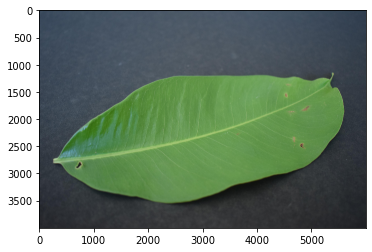

In [5]:
sample_idx = 888 # choose a random sample
sample = train_dataset[sample_idx]
data = sample[0]
label = sample[1]

plt.imshow(data.asnumpy())
print(f"Data type: {data.dtype}")
print(f"Label: {label}")
print(f"Label description: {train_dataset.synsets[label]}")
print(f"Image shape: {data.shape}")

As you can see from the plot, the image size is very large 4000 x 6000 pixels.
Usually, you downsize images before passing them to a neural network to reduce the training time.
It is also customary to make slight modifications to the images to improve generalization. That is why you add
transformations to the data in a process called Data Augmentation.

You can augment data in MXNet using `transforms`. For a complete list of all
the available transformations in MXNet check out
[available transforms](../../../api/gluon/data/vision/transforms/index.rst).
It is very common to use more than one transform per image, and it is also
common to process transforms sequentially. To this end, you can use the `transforms.Compose` class.
This class is very useful to create a transformation pipeline for your images.

You have to compose two different transformation pipelines, one for training
and the other one for validating and testing. This is because each pipeline
serves different pursposes. You need to downsize, convert to tensor and normalize
images across all the different datsets; however, you typically do not want to randomly flip
or add color jitter to the validation or test images since you could reduce performance.

In [6]:
# Import transforms as compose a series of transformations to the images
from mxnet.gluon.data.vision import transforms

jitter_param = 0.05

# mean and std for normalizing image value in range (0,1)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

training_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.RandomFlipLeftRight(),
    transforms.RandomColorJitter(contrast=jitter_param),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

validation_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

With your augmentations ready, you can create the `DataLoaders` to use them. To
do this the `gluon.data.DataLoader` class comes in handy. You have to pass the dataset with
the applied transformations (notice the `.transform_first()` method on the datasets)
to `gluon.data.DataLoader`. Additionally, you need to decide the batch size,
which is how many images you will be passing to the network,
and whether you want to shuffle the dataset.

In [7]:
# Create data loaders
batch_size = 4
train_loader = gluon.data.DataLoader(train_dataset.transform_first(training_transformer),
                                     batch_size=batch_size,
                                     shuffle=True,
                                     try_nopython=True)
validation_loader = gluon.data.DataLoader(val_dataset.transform_first(validation_transformer),
                                          batch_size=batch_size,
                                          try_nopython=True)
test_loader = gluon.data.DataLoader(test_dataset.transform_first(validation_transformer),
                                    batch_size=batch_size,
                                    try_nopython=True)

Now, you can inspect the transformations that you made to the images. A prepared
utility function has been provided for this.

In [8]:
# Function to plot batch
def show_batch(batch, columns=4, fig_size=(9, 5), pad=1):
    labels = batch[1].asnumpy()
    batch = batch[0] / 2 + 0.5     # unnormalize
    batch = np.clip(batch.asnumpy(), 0, 1) # clip values
    size = batch.shape[0]
    rows = int(size / columns)
    fig, axes = plt.subplots(rows, columns, figsize=fig_size)
    for ax, img, label in zip(axes.flatten(), batch, labels):
        ax.imshow(np.transpose(img, (1, 2, 0)))
        ax.set(title=f"Label: {label}")
    fig.tight_layout(h_pad=pad, w_pad=pad)
    plt.show()

In [9]:
for batch in train_loader:
    a = batch
    break

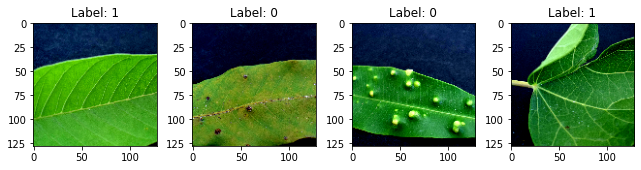

In [10]:
show_batch(a)

You can see that the original images changed to have different sizes and variations
in color and lighting. These changes followed the specified transformations you stated
in the pipeline. You are now ready to go to the next step: **Create the
architecture**.

## 2. Create Neural Network

Convolutional neural networks are a great tool to capture the spatial
relationship of pixel values within images, for this reason they have become the
gold standard for computer vision. In this example you will create a small convolutional neural
network using what you learned from [Step 2](2-create-nn.md) of this crash course series.
First, you can set up two functions that will generate the two types of blocks
you intend to use, the convolution block and the dense block. Then you can create an
entire network based on these two blocks using a custom class.

In [11]:
# The convolutional block has a convolution layer, a max pool layer and a batch normalization layer
def conv_block(filters, kernel_size=2, stride=2, batch_norm=True):
    conv_block = nn.HybridSequential()
    conv_block.add(nn.Conv2D(channels=filters, kernel_size=kernel_size, activation='relu'),
              nn.MaxPool2D(pool_size=4, strides=stride))
    if batch_norm:
        conv_block.add(nn.BatchNorm())
    return conv_block

# The dense block consists of a dense layer and a dropout layer
def dense_block(neurons, activation='relu', dropout=0.2):
    dense_block = nn.HybridSequential()
    dense_block.add(nn.Dense(neurons, activation=activation))
    if dropout:
        dense_block.add(nn.Dropout(dropout))
    return dense_block

In [12]:
# Create neural network blueprint using the blocks
class LeafNetwork(nn.HybridBlock):
    def __init__(self):
        super(LeafNetwork, self).__init__()
        self.conv1 = conv_block(32)
        self.conv2 = conv_block(64)
        self.conv3 = conv_block(128)
        self.flatten = nn.Flatten()
        self.dense1 = dense_block(100)
        self.dense2 = dense_block(10)
        self.dense3 = nn.Dense(2)

    def forward(self, batch):
        batch = self.conv1(batch)
        batch = self.conv2(batch)
        batch = self.conv3(batch)
        batch = self.flatten(batch)
        batch = self.dense1(batch)
        batch = self.dense2(batch)
        batch = self.dense3(batch)

        return batch

You have concluded the architecting part of the network, so now you can actually
build a model from that architecture for training. As you have seen
previously on [Step 4](4-components.md) of this
crash course series, to use the network you need to initialize the parameters and
hybridize the model.

In [13]:
# Create the model based on the blueprint provided and initialize the parameters
device = mx.gpu()

initializer = mx.initializer.Xavier()

model = LeafNetwork()
model.initialize(initializer, device=device)
model.summary(mx.np.random.uniform(size=(4, 3, 128, 128), device=device))
model.hybridize()

[11:01:05] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for GPU


--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                            (4, 3, 128, 128)               0
        Activation-1                           (4, 32, 127, 127)               0
            Conv2D-2                           (4, 32, 127, 127)             416
         MaxPool2D-3                             (4, 32, 62, 62)               0
         BatchNorm-4                             (4, 32, 62, 62)             128
        Activation-5                             (4, 64, 61, 61)               0
            Conv2D-6                             (4, 64, 61, 61)            8256
         MaxPool2D-7                             (4, 64, 29, 29)               0
         BatchNorm-8                             (4, 64, 29, 29)             256
        Activation-9                            (4, 128, 28, 28)               0
           Conv2D-10        

[11:01:07] /work/mxnet/src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:106: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


## 3. Choose Optimizer and Loss function

With the network created you can move on to choosing an optimizer and a loss
function. The network you created uses these components to make an informed decision on how
to tune the parameters to fit the final objective better. You can use the `gluon.Trainer` class to
help with optimizing these parameters. The `gluon.Trainer` class needs two things to work
properly: the parameters needing to be tuned and the optimizer with its
corresponding hyperparameters. The trainer uses the error reported by the loss
function to optimize these parameters.

For this particular dataset you will use Stochastic Gradient Descent as the
optimizer and Cross Entropy as the loss function.

In [14]:
# SGD optimizer
optimizer = 'sgd'

# Set parameters
optimizer_params = {'learning_rate': 0.001}

# Define the trainer for the model
trainer = gluon.Trainer(model.collect_params(), optimizer, optimizer_params)

# Define the loss function
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

Finally, you have to set up the training loop, and you need to create a function to evaluate the performance of the network on the validation dataset.

In [15]:
# Function to return the accuracy for the validation and test set
def test(val_data):
    acc = gluon.metric.Accuracy()
    for batch in val_data:
        data = batch[0]
        labels = batch[1]
        outputs = model(data.to_device(device))
        acc.update([labels], [outputs])

    _, accuracy = acc.get()
    return accuracy

## 4. Training Loop

Now that you have everything set up, you can start training your network. This might
take some time to train depending on the hardware, number of layers, batch size and
images you use. For this particular case, you will only train for 2 epochs.

In [16]:
# Start the training loop
epochs = 2
accuracy = gluon.metric.Accuracy()
log_interval = 5

for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    accuracy.reset()

    for idx, batch in enumerate(train_loader):
        data = batch[0]
        label = batch[1]
        with mx.autograd.record():
            outputs = model(data.to_device(device))
            loss = loss_fn(outputs, label.to_device(device))
        mx.autograd.backward(loss)
        trainer.step(batch_size)
        accuracy.update([label], [outputs])
        if log_interval and (idx + 1) % log_interval == 0:
            _, acc = accuracy.get()

            print(f"""Epoch[{epoch + 1}] Batch[{idx + 1}] Speed: {batch_size / (time.time() - btic)} samples/sec \
                  batch loss = {loss.mean().item()} | accuracy = {acc}""")
            btic = time.time()

    _, acc = accuracy.get()

    acc_val = test(validation_loader)
    print(f"[Epoch {epoch + 1}] training: accuracy={acc}")
    print(f"[Epoch {epoch + 1}] time cost: {time.time() - tic}")
    print(f"[Epoch {epoch + 1}] validation: validation accuracy={acc_val}")

Epoch[1] Batch[5] Speed: 1.2530893441871767 samples/sec                   batch loss = 0.6352853775024414 | accuracy = 0.45


Epoch[1] Batch[10] Speed: 1.2642544988328195 samples/sec                   batch loss = 0.6339535713195801 | accuracy = 0.475


Epoch[1] Batch[15] Speed: 1.2695347071806748 samples/sec                   batch loss = 0.6256116032600403 | accuracy = 0.5


Epoch[1] Batch[20] Speed: 1.2634938570679022 samples/sec                   batch loss = 0.8580507636070251 | accuracy = 0.475


Epoch[1] Batch[25] Speed: 1.2685050440515728 samples/sec                   batch loss = 0.9128608107566833 | accuracy = 0.52


Epoch[1] Batch[30] Speed: 1.2657726123137107 samples/sec                   batch loss = 0.9788542985916138 | accuracy = 0.5083333333333333


Epoch[1] Batch[35] Speed: 1.2653376757154078 samples/sec                   batch loss = 0.8217211961746216 | accuracy = 0.5214285714285715


Epoch[1] Batch[40] Speed: 1.2724444726245556 samples/sec                   batch loss = 0.45762553811073303 | accuracy = 0.54375


Epoch[1] Batch[45] Speed: 1.2663770172551743 samples/sec                   batch loss = 0.9639849662780762 | accuracy = 0.5555555555555556


Epoch[1] Batch[50] Speed: 1.268789961132133 samples/sec                   batch loss = 0.6110656261444092 | accuracy = 0.565


Epoch[1] Batch[55] Speed: 1.2728466469036699 samples/sec                   batch loss = 0.4847654402256012 | accuracy = 0.5727272727272728


Epoch[1] Batch[60] Speed: 1.2731870427851208 samples/sec                   batch loss = 0.36140891909599304 | accuracy = 0.5708333333333333


Epoch[1] Batch[65] Speed: 1.2720178627615253 samples/sec                   batch loss = 0.6914586424827576 | accuracy = 0.573076923076923


Epoch[1] Batch[70] Speed: 1.2724605894593808 samples/sec                   batch loss = 0.5660839676856995 | accuracy = 0.575


Epoch[1] Batch[75] Speed: 1.2702094482318143 samples/sec                   batch loss = 0.76222825050354 | accuracy = 0.5733333333333334


Epoch[1] Batch[80] Speed: 1.2723079301977038 samples/sec                   batch loss = 0.4101654887199402 | accuracy = 0.58125


Epoch[1] Batch[85] Speed: 1.2647879413592846 samples/sec                   batch loss = 0.44113361835479736 | accuracy = 0.6


Epoch[1] Batch[90] Speed: 1.2628637771643567 samples/sec                   batch loss = 0.4454190135002136 | accuracy = 0.6055555555555555


Epoch[1] Batch[95] Speed: 1.2687136829050651 samples/sec                   batch loss = 0.3648921549320221 | accuracy = 0.6210526315789474


Epoch[1] Batch[100] Speed: 1.2685668131859988 samples/sec                   batch loss = 0.6214966177940369 | accuracy = 0.615


Epoch[1] Batch[105] Speed: 1.2636509756130627 samples/sec                   batch loss = 0.7490622997283936 | accuracy = 0.6166666666666667


Epoch[1] Batch[110] Speed: 1.2608393247543455 samples/sec                   batch loss = 0.644011378288269 | accuracy = 0.6272727272727273


Epoch[1] Batch[115] Speed: 1.2728958983796488 samples/sec                   batch loss = 0.5559371113777161 | accuracy = 0.6260869565217392


Epoch[1] Batch[120] Speed: 1.2690510075993067 samples/sec                   batch loss = 0.6472988128662109 | accuracy = 0.6270833333333333


Epoch[1] Batch[125] Speed: 1.2711808145620573 samples/sec                   batch loss = 0.23287108540534973 | accuracy = 0.638


Epoch[1] Batch[130] Speed: 1.2699505204822585 samples/sec                   batch loss = 0.670931875705719 | accuracy = 0.6480769230769231


Epoch[1] Batch[135] Speed: 1.2694621815688147 samples/sec                   batch loss = 0.6365534067153931 | accuracy = 0.6481481481481481


Epoch[1] Batch[140] Speed: 1.2711095453210974 samples/sec                   batch loss = 0.8047107458114624 | accuracy = 0.6482142857142857


Epoch[1] Batch[145] Speed: 1.275706733724113 samples/sec                   batch loss = 0.16669893264770508 | accuracy = 0.653448275862069


Epoch[1] Batch[150] Speed: 1.2717913606779485 samples/sec                   batch loss = 0.43030601739883423 | accuracy = 0.6566666666666666


Epoch[1] Batch[155] Speed: 1.2713519896929137 samples/sec                   batch loss = 0.6642858386039734 | accuracy = 0.6516129032258065


Epoch[1] Batch[160] Speed: 1.2756304945135366 samples/sec                   batch loss = 0.4983450174331665 | accuracy = 0.653125


Epoch[1] Batch[165] Speed: 1.267467474394495 samples/sec                   batch loss = 0.18575376272201538 | accuracy = 0.6590909090909091


Epoch[1] Batch[170] Speed: 1.27228207245916 samples/sec                   batch loss = 0.41208794713020325 | accuracy = 0.6573529411764706


Epoch[1] Batch[175] Speed: 1.2672499602313576 samples/sec                   batch loss = 0.32199615240097046 | accuracy = 0.6557142857142857


Epoch[1] Batch[180] Speed: 1.269519625013384 samples/sec                   batch loss = 0.49476495385169983 | accuracy = 0.6555555555555556


Epoch[1] Batch[185] Speed: 1.277679993907547 samples/sec                   batch loss = 0.5171438455581665 | accuracy = 0.6527027027027027


Epoch[1] Batch[190] Speed: 1.2694573788407175 samples/sec                   batch loss = 0.9517772793769836 | accuracy = 0.6486842105263158


Epoch[1] Batch[195] Speed: 1.2658846406641397 samples/sec                   batch loss = 0.4889824092388153 | accuracy = 0.65


Epoch[1] Batch[200] Speed: 1.2683026100677 samples/sec                   batch loss = 0.2717404365539551 | accuracy = 0.64875


Epoch[1] Batch[205] Speed: 1.2696245351536626 samples/sec                   batch loss = 0.22775080800056458 | accuracy = 0.6536585365853659


Epoch[1] Batch[210] Speed: 1.2662904198970104 samples/sec                   batch loss = 0.3224545121192932 | accuracy = 0.655952380952381


Epoch[1] Batch[215] Speed: 1.2699999326288736 samples/sec                   batch loss = 0.5677539706230164 | accuracy = 0.6581395348837209


Epoch[1] Batch[220] Speed: 1.2717318798922048 samples/sec                   batch loss = 0.5631413459777832 | accuracy = 0.6625


Epoch[1] Batch[225] Speed: 1.2695807244152357 samples/sec                   batch loss = 0.2768310010433197 | accuracy = 0.6677777777777778


Epoch[1] Batch[230] Speed: 1.2705994331792356 samples/sec                   batch loss = 0.9577723741531372 | accuracy = 0.6663043478260869


Epoch[1] Batch[235] Speed: 1.2730117992417114 samples/sec                   batch loss = 0.447670042514801 | accuracy = 0.6680851063829787


Epoch[1] Batch[240] Speed: 1.2741452620815545 samples/sec                   batch loss = 0.4830113649368286 | accuracy = 0.6729166666666667


Epoch[1] Batch[245] Speed: 1.273162501919926 samples/sec                   batch loss = 0.6537089943885803 | accuracy = 0.6755102040816326


Epoch[1] Batch[250] Speed: 1.271738435038251 samples/sec                   batch loss = 0.27009671926498413 | accuracy = 0.678


Epoch[1] Batch[255] Speed: 1.2734487420140073 samples/sec                   batch loss = 0.9262614250183105 | accuracy = 0.6784313725490196


Epoch[1] Batch[260] Speed: 1.2739796220558062 samples/sec                   batch loss = 0.40350914001464844 | accuracy = 0.6798076923076923


Epoch[1] Batch[265] Speed: 1.2712769443857406 samples/sec                   batch loss = 0.6463271379470825 | accuracy = 0.6811320754716981


Epoch[1] Batch[270] Speed: 1.2702385878175413 samples/sec                   batch loss = 0.5091599822044373 | accuracy = 0.6796296296296296


Epoch[1] Batch[275] Speed: 1.2732436642960268 samples/sec                   batch loss = 1.1342508792877197 | accuracy = 0.6790909090909091


Epoch[1] Batch[280] Speed: 1.274236614725693 samples/sec                   batch loss = 0.40833780169487 | accuracy = 0.6821428571428572


Epoch[1] Batch[285] Speed: 1.274778612929251 samples/sec                   batch loss = 0.5412454009056091 | accuracy = 0.6815789473684211


Epoch[1] Batch[290] Speed: 1.2705455482859405 samples/sec                   batch loss = 0.8457198739051819 | accuracy = 0.6827586206896552


Epoch[1] Batch[295] Speed: 1.269695445782084 samples/sec                   batch loss = 0.5659967064857483 | accuracy = 0.6813559322033899


Epoch[1] Batch[300] Speed: 1.2706743985164421 samples/sec                   batch loss = 0.6480209231376648 | accuracy = 0.6816666666666666


Epoch[1] Batch[305] Speed: 1.2735922970558664 samples/sec                   batch loss = 0.4945051670074463 | accuracy = 0.6819672131147541


Epoch[1] Batch[310] Speed: 1.2725645383753252 samples/sec                   batch loss = 0.8833675980567932 | accuracy = 0.682258064516129


Epoch[1] Batch[315] Speed: 1.272630951030016 samples/sec                   batch loss = 0.6608326435089111 | accuracy = 0.6817460317460318


Epoch[1] Batch[320] Speed: 1.2764571963237714 samples/sec                   batch loss = 0.7957041263580322 | accuracy = 0.6828125


Epoch[1] Batch[325] Speed: 1.2736890820507276 samples/sec                   batch loss = 0.6105384826660156 | accuracy = 0.683076923076923


Epoch[1] Batch[330] Speed: 1.2693770826099848 samples/sec                   batch loss = 0.9845757484436035 | accuracy = 0.6818181818181818


Epoch[1] Batch[335] Speed: 1.2729998218415033 samples/sec                   batch loss = 0.6528548002243042 | accuracy = 0.682089552238806


Epoch[1] Batch[340] Speed: 1.279472775843633 samples/sec                   batch loss = 0.9312818050384521 | accuracy = 0.6816176470588236


Epoch[1] Batch[345] Speed: 1.274204388197998 samples/sec                   batch loss = 0.11114921420812607 | accuracy = 0.6818840579710145


Epoch[1] Batch[350] Speed: 1.2701791560204634 samples/sec                   batch loss = 0.6661850214004517 | accuracy = 0.6835714285714286


Epoch[1] Batch[355] Speed: 1.2770967367960882 samples/sec                   batch loss = 0.1835106760263443 | accuracy = 0.6852112676056338


Epoch[1] Batch[360] Speed: 1.270910226502724 samples/sec                   batch loss = 0.5230139493942261 | accuracy = 0.6833333333333333


Epoch[1] Batch[365] Speed: 1.2754757162114092 samples/sec                   batch loss = 0.4571453630924225 | accuracy = 0.6863013698630137


Epoch[1] Batch[370] Speed: 1.2770803078837552 samples/sec                   batch loss = 0.40805724263191223 | accuracy = 0.6858108108108109


Epoch[1] Batch[375] Speed: 1.274063404209238 samples/sec                   batch loss = 0.26831990480422974 | accuracy = 0.6866666666666666


Epoch[1] Batch[380] Speed: 1.269979167522985 samples/sec                   batch loss = 0.6408670544624329 | accuracy = 0.6855263157894737


Epoch[1] Batch[385] Speed: 1.2721657256411305 samples/sec                   batch loss = 0.36049652099609375 | accuracy = 0.685064935064935


Epoch[1] Batch[390] Speed: 1.2702908116082354 samples/sec                   batch loss = 0.3294156491756439 | accuracy = 0.6884615384615385


Epoch[1] Batch[395] Speed: 1.2646885956438496 samples/sec                   batch loss = 0.5008577704429626 | accuracy = 0.6886075949367089


Epoch[1] Batch[400] Speed: 1.2714222262538604 samples/sec                   batch loss = 0.45107215642929077 | accuracy = 0.688125


Epoch[1] Batch[405] Speed: 1.2779346854825915 samples/sec                   batch loss = 0.8759376406669617 | accuracy = 0.6882716049382716


Epoch[1] Batch[410] Speed: 1.2688593391065173 samples/sec                   batch loss = 0.4587867259979248 | accuracy = 0.6890243902439024


Epoch[1] Batch[415] Speed: 1.2678114178032829 samples/sec                   batch loss = 0.23589114844799042 | accuracy = 0.6897590361445783


Epoch[1] Batch[420] Speed: 1.2703374607979452 samples/sec                   batch loss = 0.5983176231384277 | accuracy = 0.6916666666666667


Epoch[1] Batch[425] Speed: 1.2725378015165434 samples/sec                   batch loss = 0.42525193095207214 | accuracy = 0.6911764705882353


Epoch[1] Batch[430] Speed: 1.2678025079753326 samples/sec                   batch loss = 0.1402614861726761 | accuracy = 0.6936046511627907


Epoch[1] Batch[435] Speed: 1.2688565561648035 samples/sec                   batch loss = 0.5064120292663574 | accuracy = 0.6919540229885057


Epoch[1] Batch[440] Speed: 1.2722175291832039 samples/sec                   batch loss = 0.659964382648468 | accuracy = 0.69375


Epoch[1] Batch[445] Speed: 1.2685812012705158 samples/sec                   batch loss = 0.5375582575798035 | accuracy = 0.6955056179775281


Epoch[1] Batch[450] Speed: 1.2749579281459469 samples/sec                   batch loss = 0.2777075171470642 | accuracy = 0.6966666666666667


Epoch[1] Batch[455] Speed: 1.2684520079645996 samples/sec                   batch loss = 0.39772549271583557 | accuracy = 0.6978021978021978


Epoch[1] Batch[460] Speed: 1.2767185900983251 samples/sec                   batch loss = 0.46377918124198914 | accuracy = 0.7


Epoch[1] Batch[465] Speed: 1.2732341948189438 samples/sec                   batch loss = 0.4168350398540497 | accuracy = 0.7


Epoch[1] Batch[470] Speed: 1.2702242582832288 samples/sec                   batch loss = 0.6971716284751892 | accuracy = 0.6978723404255319


Epoch[1] Batch[475] Speed: 1.2719755261018497 samples/sec                   batch loss = 0.6274775266647339 | accuracy = 0.6984210526315789


Epoch[1] Batch[480] Speed: 1.2699944528822 samples/sec                   batch loss = 0.6770452260971069 | accuracy = 0.6994791666666667


Epoch[1] Batch[485] Speed: 1.2721107432565995 samples/sec                   batch loss = 0.6677770614624023 | accuracy = 0.6989690721649484


Epoch[1] Batch[490] Speed: 1.26774579458687 samples/sec                   batch loss = 0.4625701904296875 | accuracy = 0.6989795918367347


Epoch[1] Batch[495] Speed: 1.275942589787115 samples/sec                   batch loss = 0.24697497487068176 | accuracy = 0.6989898989898989


Epoch[1] Batch[500] Speed: 1.2685111823298978 samples/sec                   batch loss = 0.509066104888916 | accuracy = 0.7005


Epoch[1] Batch[505] Speed: 1.26948561940332 samples/sec                   batch loss = 0.4165802001953125 | accuracy = 0.7019801980198019


Epoch[1] Batch[510] Speed: 1.2722039267273964 samples/sec                   batch loss = 0.33917945623397827 | accuracy = 0.7029411764705882


Epoch[1] Batch[515] Speed: 1.272213187942301 samples/sec                   batch loss = 1.977638602256775 | accuracy = 0.7014563106796117


Epoch[1] Batch[520] Speed: 1.2730111230921488 samples/sec                   batch loss = 1.0896482467651367 | accuracy = 0.6995192307692307


Epoch[1] Batch[525] Speed: 1.2707320479692332 samples/sec                   batch loss = 0.24509252607822418 | accuracy = 0.7


Epoch[1] Batch[530] Speed: 1.2675404426097232 samples/sec                   batch loss = 0.8742809891700745 | accuracy = 0.6995283018867925


Epoch[1] Batch[535] Speed: 1.2688577077254115 samples/sec                   batch loss = 0.3965678811073303 | accuracy = 0.6981308411214954


Epoch[1] Batch[540] Speed: 1.2722785991116687 samples/sec                   batch loss = 1.041693925857544 | accuracy = 0.6990740740740741


Epoch[1] Batch[545] Speed: 1.2673274985300187 samples/sec                   batch loss = 0.7918975353240967 | accuracy = 0.6990825688073394


Epoch[1] Batch[550] Speed: 1.2707386890602221 samples/sec                   batch loss = 0.44968700408935547 | accuracy = 0.6986363636363636


Epoch[1] Batch[555] Speed: 1.272466187018494 samples/sec                   batch loss = 0.27668505907058716 | accuracy = 0.6972972972972973


Epoch[1] Batch[560] Speed: 1.2658237054785988 samples/sec                   batch loss = 0.5189111232757568 | accuracy = 0.6991071428571428


Epoch[1] Batch[565] Speed: 1.2690659826390498 samples/sec                   batch loss = 0.4676710069179535 | accuracy = 0.6991150442477876


Epoch[1] Batch[570] Speed: 1.2683356893667634 samples/sec                   batch loss = 0.4415740668773651 | accuracy = 0.7


Epoch[1] Batch[575] Speed: 1.2662089947756816 samples/sec                   batch loss = 0.5262657403945923 | accuracy = 0.7


Epoch[1] Batch[580] Speed: 1.2665701356919505 samples/sec                   batch loss = 0.37578219175338745 | accuracy = 0.7004310344827587


Epoch[1] Batch[585] Speed: 1.269539894760531 samples/sec                   batch loss = 0.6460081934928894 | accuracy = 0.6987179487179487


Epoch[1] Batch[590] Speed: 1.2717250356206529 samples/sec                   batch loss = 0.744674563407898 | accuracy = 0.6991525423728814


Epoch[1] Batch[595] Speed: 1.2687186718924166 samples/sec                   batch loss = 0.4731118381023407 | accuracy = 0.6987394957983193


Epoch[1] Batch[600] Speed: 1.2663384962172992 samples/sec                   batch loss = 0.27245140075683594 | accuracy = 0.7


Epoch[1] Batch[605] Speed: 1.2678767603683316 samples/sec                   batch loss = 0.4969082176685333 | accuracy = 0.7012396694214876


Epoch[1] Batch[610] Speed: 1.2705027322991986 samples/sec                   batch loss = 0.6262919306755066 | accuracy = 0.7012295081967214


Epoch[1] Batch[615] Speed: 1.270636674160224 samples/sec                   batch loss = 0.6298666000366211 | accuracy = 0.7008130081300813


Epoch[1] Batch[620] Speed: 1.2734461322218864 samples/sec                   batch loss = 0.56578528881073 | accuracy = 0.7004032258064516


Epoch[1] Batch[625] Speed: 1.272271170070974 samples/sec                   batch loss = 0.4613010585308075 | accuracy = 0.6996


Epoch[1] Batch[630] Speed: 1.2704150887961538 samples/sec                   batch loss = 0.7163822054862976 | accuracy = 0.6992063492063492


Epoch[1] Batch[635] Speed: 1.2729531700845214 samples/sec                   batch loss = 1.675323247909546 | accuracy = 0.6988188976377953


Epoch[1] Batch[640] Speed: 1.2703234175886307 samples/sec                   batch loss = 0.370064377784729 | accuracy = 0.6984375


Epoch[1] Batch[645] Speed: 1.2667758429100389 samples/sec                   batch loss = 0.5859667658805847 | accuracy = 0.6980620155038759


Epoch[1] Batch[650] Speed: 1.2685477254975792 samples/sec                   batch loss = 0.6440365314483643 | accuracy = 0.6988461538461539


Epoch[1] Batch[655] Speed: 1.2678543400195408 samples/sec                   batch loss = 0.5757941603660583 | accuracy = 0.6984732824427481


Epoch[1] Batch[660] Speed: 1.2678121842459456 samples/sec                   batch loss = 0.5867675542831421 | accuracy = 0.6988636363636364


Epoch[1] Batch[665] Speed: 1.2764284505140226 samples/sec                   batch loss = 0.19770127534866333 | accuracy = 0.7


Epoch[1] Batch[670] Speed: 1.2682912963846036 samples/sec                   batch loss = 0.5057104825973511 | accuracy = 0.7


Epoch[1] Batch[675] Speed: 1.2704857029223597 samples/sec                   batch loss = 0.4146324098110199 | accuracy = 0.6996296296296296


Epoch[1] Batch[680] Speed: 1.2741091697846891 samples/sec                   batch loss = 0.2719554305076599 | accuracy = 0.700735294117647


Epoch[1] Batch[685] Speed: 1.274594119134764 samples/sec                   batch loss = 0.4635797142982483 | accuracy = 0.7007299270072993


Epoch[1] Batch[690] Speed: 1.2741719697623297 samples/sec                   batch loss = 0.1277836412191391 | accuracy = 0.7003623188405798


Epoch[1] Batch[695] Speed: 1.2693730488568034 samples/sec                   batch loss = 0.9319220781326294 | accuracy = 0.7


Epoch[1] Batch[700] Speed: 1.2714638515817536 samples/sec                   batch loss = 0.7549508810043335 | accuracy = 0.7


Epoch[1] Batch[705] Speed: 1.2726599122067883 samples/sec                   batch loss = 0.30876272916793823 | accuracy = 0.701063829787234


Epoch[1] Batch[710] Speed: 1.2749062887170763 samples/sec                   batch loss = 0.3817732632160187 | accuracy = 0.701056338028169


Epoch[1] Batch[715] Speed: 1.2658370763335125 samples/sec                   batch loss = 0.7625333070755005 | accuracy = 0.7006993006993008


Epoch[1] Batch[720] Speed: 1.2677617926134048 samples/sec                   batch loss = 0.6930621266365051 | accuracy = 0.7010416666666667


Epoch[1] Batch[725] Speed: 1.2675773129474892 samples/sec                   batch loss = 0.77280193567276 | accuracy = 0.7003448275862069


Epoch[1] Batch[730] Speed: 1.2628299370768479 samples/sec                   batch loss = 0.7190701365470886 | accuracy = 0.7


Epoch[1] Batch[735] Speed: 1.2652885302622696 samples/sec                   batch loss = 0.513911247253418 | accuracy = 0.6989795918367347


Epoch[1] Batch[740] Speed: 1.2718280930829422 samples/sec                   batch loss = 0.4721411168575287 | accuracy = 0.7


Epoch[1] Batch[745] Speed: 1.2685373665905568 samples/sec                   batch loss = 0.573065996170044 | accuracy = 0.6996644295302014


Epoch[1] Batch[750] Speed: 1.2753608205260436 samples/sec                   batch loss = 0.5375216007232666 | accuracy = 0.6993333333333334


Epoch[1] Batch[755] Speed: 1.2701648278270097 samples/sec                   batch loss = 0.4784156084060669 | accuracy = 0.6993377483443709


Epoch[1] Batch[760] Speed: 1.2757099348063359 samples/sec                   batch loss = 0.5781387686729431 | accuracy = 0.6990131578947368


Epoch[1] Batch[765] Speed: 1.2713529531049044 samples/sec                   batch loss = 0.5242332816123962 | accuracy = 0.699673202614379


Epoch[1] Batch[770] Speed: 1.275622250361195 samples/sec                   batch loss = 0.38947489857673645 | accuracy = 0.7003246753246753


Epoch[1] Batch[775] Speed: 1.276319985588428 samples/sec                   batch loss = 0.5402880907058716 | accuracy = 0.7


Epoch[1] Batch[780] Speed: 1.2715888402974103 samples/sec                   batch loss = 0.43696075677871704 | accuracy = 0.7


Epoch[1] Batch[785] Speed: 1.2747599190005623 samples/sec                   batch loss = 0.3778357207775116 | accuracy = 0.7009554140127389


[Epoch 1] training: accuracy=0.7008248730964467
[Epoch 1] time cost: 638.38742852211
[Epoch 1] validation: validation accuracy=0.78


Epoch[2] Batch[5] Speed: 1.2691202221192772 samples/sec                   batch loss = 0.5780384540557861 | accuracy = 0.65


Epoch[2] Batch[10] Speed: 1.2710434839461706 samples/sec                   batch loss = 0.44894179701805115 | accuracy = 0.725


Epoch[2] Batch[15] Speed: 1.274807865669183 samples/sec                   batch loss = 0.759761393070221 | accuracy = 0.75


Epoch[2] Batch[20] Speed: 1.2766534016245714 samples/sec                   batch loss = 0.49000468850135803 | accuracy = 0.6875


Epoch[2] Batch[25] Speed: 1.2653690735471126 samples/sec                   batch loss = 0.29067879915237427 | accuracy = 0.71


Epoch[2] Batch[30] Speed: 1.2685958774529627 samples/sec                   batch loss = 0.2875281572341919 | accuracy = 0.7166666666666667


Epoch[2] Batch[35] Speed: 1.2687322958654395 samples/sec                   batch loss = 1.0222852230072021 | accuracy = 0.7285714285714285


Epoch[2] Batch[40] Speed: 1.269530288164607 samples/sec                   batch loss = 0.20717427134513855 | accuracy = 0.74375


Epoch[2] Batch[45] Speed: 1.269979840455585 samples/sec                   batch loss = 0.2594929337501526 | accuracy = 0.7444444444444445


Epoch[2] Batch[50] Speed: 1.267785550906825 samples/sec                   batch loss = 0.22926674783229828 | accuracy = 0.75


Epoch[2] Batch[55] Speed: 1.2722891156942353 samples/sec                   batch loss = 0.5564077496528625 | accuracy = 0.7454545454545455


Epoch[2] Batch[60] Speed: 1.2748415757893703 samples/sec                   batch loss = 0.2967374324798584 | accuracy = 0.75


Epoch[2] Batch[65] Speed: 1.2657624896715352 samples/sec                   batch loss = 0.251403272151947 | accuracy = 0.75


Epoch[2] Batch[70] Speed: 1.279459700817564 samples/sec                   batch loss = 0.5156672596931458 | accuracy = 0.7464285714285714


Epoch[2] Batch[75] Speed: 1.2716370306365303 samples/sec                   batch loss = 0.11848552525043488 | accuracy = 0.7533333333333333


Epoch[2] Batch[80] Speed: 1.2725166637844463 samples/sec                   batch loss = 0.6070966720581055 | accuracy = 0.740625


Epoch[2] Batch[85] Speed: 1.2682839138358188 samples/sec                   batch loss = 0.538736879825592 | accuracy = 0.7382352941176471


Epoch[2] Batch[90] Speed: 1.2746679102439298 samples/sec                   batch loss = 0.3233923316001892 | accuracy = 0.7388888888888889


Epoch[2] Batch[95] Speed: 1.2697737641492013 samples/sec                   batch loss = 0.6404894590377808 | accuracy = 0.7473684210526316


Epoch[2] Batch[100] Speed: 1.2673409011730061 samples/sec                   batch loss = 0.13136443495750427 | accuracy = 0.7475


Epoch[2] Batch[105] Speed: 1.2760296389187604 samples/sec                   batch loss = 0.4038037359714508 | accuracy = 0.7476190476190476


Epoch[2] Batch[110] Speed: 1.270871236653827 samples/sec                   batch loss = 0.7497228384017944 | accuracy = 0.7522727272727273


Epoch[2] Batch[115] Speed: 1.2698334463480894 samples/sec                   batch loss = 0.15642565488815308 | accuracy = 0.7565217391304347


Epoch[2] Batch[120] Speed: 1.2747170122118094 samples/sec                   batch loss = 0.42816051840782166 | accuracy = 0.7583333333333333


Epoch[2] Batch[125] Speed: 1.2680493469444765 samples/sec                   batch loss = 0.5844265818595886 | accuracy = 0.756


Epoch[2] Batch[130] Speed: 1.2710964480596312 samples/sec                   batch loss = 0.8744387626647949 | accuracy = 0.7538461538461538


Epoch[2] Batch[135] Speed: 1.2769297454126982 samples/sec                   batch loss = 0.3346107006072998 | accuracy = 0.7537037037037037


Epoch[2] Batch[140] Speed: 1.2707765157282038 samples/sec                   batch loss = 0.13656146824359894 | accuracy = 0.7535714285714286


Epoch[2] Batch[145] Speed: 1.2701247298360547 samples/sec                   batch loss = 0.18086104094982147 | accuracy = 0.7586206896551724


Epoch[2] Batch[150] Speed: 1.2746734303947767 samples/sec                   batch loss = 0.29039373993873596 | accuracy = 0.76


Epoch[2] Batch[155] Speed: 1.2642331590592364 samples/sec                   batch loss = 0.5564824342727661 | accuracy = 0.7612903225806451


Epoch[2] Batch[160] Speed: 1.2696087783118468 samples/sec                   batch loss = 0.4719482660293579 | accuracy = 0.753125


Epoch[2] Batch[165] Speed: 1.266979224964871 samples/sec                   batch loss = 0.8218878507614136 | accuracy = 0.7484848484848485


Epoch[2] Batch[170] Speed: 1.2704914755413284 samples/sec                   batch loss = 0.13129431009292603 | accuracy = 0.7485294117647059


Epoch[2] Batch[175] Speed: 1.2680700489897896 samples/sec                   batch loss = 0.6422533988952637 | accuracy = 0.7428571428571429


Epoch[2] Batch[180] Speed: 1.268926901161117 samples/sec                   batch loss = 0.25456300377845764 | accuracy = 0.7444444444444445


Epoch[2] Batch[185] Speed: 1.2686963176973711 samples/sec                   batch loss = 0.34716543555259705 | accuracy = 0.7445945945945946


Epoch[2] Batch[190] Speed: 1.2740825614918991 samples/sec                   batch loss = 0.3880452811717987 | accuracy = 0.7421052631578947


Epoch[2] Batch[195] Speed: 1.2649567313763965 samples/sec                   batch loss = 0.603451132774353 | accuracy = 0.7384615384615385


Epoch[2] Batch[200] Speed: 1.2722398146862526 samples/sec                   batch loss = 0.2720002830028534 | accuracy = 0.74125


Epoch[2] Batch[205] Speed: 1.2738687679219722 samples/sec                   batch loss = 0.18051964044570923 | accuracy = 0.7426829268292683


Epoch[2] Batch[210] Speed: 1.2686211059326953 samples/sec                   batch loss = 0.4530982971191406 | accuracy = 0.7464285714285714


Epoch[2] Batch[215] Speed: 1.2668695856973722 samples/sec                   batch loss = 0.4215467572212219 | accuracy = 0.7476744186046511


Epoch[2] Batch[220] Speed: 1.2658882702176777 samples/sec                   batch loss = 0.5549020767211914 | accuracy = 0.7465909090909091


Epoch[2] Batch[225] Speed: 1.2750096686545072 samples/sec                   batch loss = 0.42928093671798706 | accuracy = 0.7422222222222222


Epoch[2] Batch[230] Speed: 1.26767366478703 samples/sec                   batch loss = 0.6929038763046265 | accuracy = 0.7402173913043478


Epoch[2] Batch[235] Speed: 1.2706518791159613 samples/sec                   batch loss = 0.17485356330871582 | accuracy = 0.7414893617021276


Epoch[2] Batch[240] Speed: 1.274108298950243 samples/sec                   batch loss = 0.7340457439422607 | accuracy = 0.7385416666666667


Epoch[2] Batch[245] Speed: 1.2756631812016035 samples/sec                   batch loss = 0.5801991820335388 | accuracy = 0.7408163265306122


Epoch[2] Batch[250] Speed: 1.2722220633997792 samples/sec                   batch loss = 0.623143196105957 | accuracy = 0.736


Epoch[2] Batch[255] Speed: 1.279618570727857 samples/sec                   batch loss = 0.5140345096588135 | accuracy = 0.7392156862745098


Epoch[2] Batch[260] Speed: 1.2719711865123813 samples/sec                   batch loss = 0.45163509249687195 | accuracy = 0.7384615384615385


Epoch[2] Batch[265] Speed: 1.2761241739470932 samples/sec                   batch loss = 0.595408022403717 | accuracy = 0.7386792452830189


Epoch[2] Batch[270] Speed: 1.2725531485291683 samples/sec                   batch loss = 0.5978537797927856 | accuracy = 0.7361111111111112


Epoch[2] Batch[275] Speed: 1.2781001872293252 samples/sec                   batch loss = 0.41133081912994385 | accuracy = 0.7354545454545455


Epoch[2] Batch[280] Speed: 1.273421001437808 samples/sec                   batch loss = 0.4558979868888855 | accuracy = 0.7339285714285714


Epoch[2] Batch[285] Speed: 1.2726813443262295 samples/sec                   batch loss = 0.27079078555107117 | accuracy = 0.7350877192982456


Epoch[2] Batch[290] Speed: 1.269854975603461 samples/sec                   batch loss = 0.13219739496707916 | accuracy = 0.7353448275862069


Epoch[2] Batch[295] Speed: 1.2757205081920855 samples/sec                   batch loss = 0.4360290467739105 | accuracy = 0.7364406779661017


Epoch[2] Batch[300] Speed: 1.2769724125143969 samples/sec                   batch loss = 0.8739743232727051 | accuracy = 0.7375


Epoch[2] Batch[305] Speed: 1.2725361606628844 samples/sec                   batch loss = 0.38719305396080017 | accuracy = 0.7344262295081967


Epoch[2] Batch[310] Speed: 1.2746681039326238 samples/sec                   batch loss = 0.25411537289619446 | accuracy = 0.7354838709677419


Epoch[2] Batch[315] Speed: 1.2727556865509455 samples/sec                   batch loss = 1.2306097745895386 | accuracy = 0.7365079365079366


Epoch[2] Batch[320] Speed: 1.2686967973928567 samples/sec                   batch loss = 0.5120067596435547 | accuracy = 0.7359375


Epoch[2] Batch[325] Speed: 1.270569411031978 samples/sec                   batch loss = 0.20576894283294678 | accuracy = 0.7392307692307692


Epoch[2] Batch[330] Speed: 1.2771791793774567 samples/sec                   batch loss = 0.3455173373222351 | accuracy = 0.7386363636363636


Epoch[2] Batch[335] Speed: 1.274573590843974 samples/sec                   batch loss = 0.7510959506034851 | accuracy = 0.7402985074626866


Epoch[2] Batch[340] Speed: 1.2695764011510113 samples/sec                   batch loss = 0.6387460827827454 | accuracy = 0.7397058823529412


Epoch[2] Batch[345] Speed: 1.2705491083968077 samples/sec                   batch loss = 0.7640165090560913 | accuracy = 0.7391304347826086


Epoch[2] Batch[350] Speed: 1.2652037991068954 samples/sec                   batch loss = 1.4234281778335571 | accuracy = 0.7407142857142858


Epoch[2] Batch[355] Speed: 1.2681458664169865 samples/sec                   batch loss = 0.3177753984928131 | accuracy = 0.7429577464788732


Epoch[2] Batch[360] Speed: 1.2716389583260697 samples/sec                   batch loss = 0.556742787361145 | accuracy = 0.7416666666666667


Epoch[2] Batch[365] Speed: 1.2653629656401473 samples/sec                   batch loss = 0.43005675077438354 | accuracy = 0.7417808219178083


Epoch[2] Batch[370] Speed: 1.2714472782079833 samples/sec                   batch loss = 0.30676719546318054 | accuracy = 0.7412162162162163


Epoch[2] Batch[375] Speed: 1.2690710703932413 samples/sec                   batch loss = 0.6052951216697693 | accuracy = 0.7393333333333333


Epoch[2] Batch[380] Speed: 1.2700011824022812 samples/sec                   batch loss = 0.39508527517318726 | accuracy = 0.7381578947368421


Epoch[2] Batch[385] Speed: 1.2765008030811533 samples/sec                   batch loss = 0.37119513750076294 | accuracy = 0.7389610389610389


Epoch[2] Batch[390] Speed: 1.2709357396740169 samples/sec                   batch loss = 0.30138570070266724 | accuracy = 0.7397435897435898


Epoch[2] Batch[395] Speed: 1.2692381249803304 samples/sec                   batch loss = 0.5999253988265991 | accuracy = 0.7398734177215189


Epoch[2] Batch[400] Speed: 1.2717881792309058 samples/sec                   batch loss = 0.539286196231842 | accuracy = 0.740625


Epoch[2] Batch[405] Speed: 1.2713913944347617 samples/sec                   batch loss = 0.30317020416259766 | accuracy = 0.7425925925925926


Epoch[2] Batch[410] Speed: 1.2728221191589544 samples/sec                   batch loss = 0.9465358853340149 | accuracy = 0.7426829268292683


Epoch[2] Batch[415] Speed: 1.2709587505447735 samples/sec                   batch loss = 0.17237769067287445 | accuracy = 0.7433734939759036


Epoch[2] Batch[420] Speed: 1.2785354666521975 samples/sec                   batch loss = 0.6054416298866272 | accuracy = 0.7446428571428572


Epoch[2] Batch[425] Speed: 1.273354602946476 samples/sec                   batch loss = 0.3936050534248352 | accuracy = 0.7458823529411764


Epoch[2] Batch[430] Speed: 1.2700116613683958 samples/sec                   batch loss = 0.8269366025924683 | accuracy = 0.7441860465116279


Epoch[2] Batch[435] Speed: 1.2740278002849497 samples/sec                   batch loss = 0.23127706348896027 | accuracy = 0.743103448275862


Epoch[2] Batch[440] Speed: 1.2735812755218736 samples/sec                   batch loss = 0.5223276615142822 | accuracy = 0.7414772727272727


Epoch[2] Batch[445] Speed: 1.266304182923915 samples/sec                   batch loss = 0.4478244185447693 | accuracy = 0.7410112359550561


Epoch[2] Batch[450] Speed: 1.2710393433015112 samples/sec                   batch loss = 0.3408970236778259 | accuracy = 0.7427777777777778


Epoch[2] Batch[455] Speed: 1.2716971773037002 samples/sec                   batch loss = 1.2761095762252808 | accuracy = 0.7423076923076923


Epoch[2] Batch[460] Speed: 1.2686047984356823 samples/sec                   batch loss = 0.2917778491973877 | accuracy = 0.7445652173913043


Epoch[2] Batch[465] Speed: 1.2668178341371183 samples/sec                   batch loss = 0.3834354281425476 | accuracy = 0.7446236559139785


Epoch[2] Batch[470] Speed: 1.2661087568665537 samples/sec                   batch loss = 0.4437936842441559 | accuracy = 0.7457446808510638


Epoch[2] Batch[475] Speed: 1.2642730764544172 samples/sec                   batch loss = 0.5181235074996948 | accuracy = 0.7452631578947368


Epoch[2] Batch[480] Speed: 1.273369293136964 samples/sec                   batch loss = 0.547238290309906 | accuracy = 0.7453125


Epoch[2] Batch[485] Speed: 1.275819557316009 samples/sec                   batch loss = 0.38005489110946655 | accuracy = 0.7443298969072165


Epoch[2] Batch[490] Speed: 1.2673671328803393 samples/sec                   batch loss = 0.4808540344238281 | accuracy = 0.7448979591836735


Epoch[2] Batch[495] Speed: 1.2691978934476054 samples/sec                   batch loss = 0.3286842405796051 | accuracy = 0.7444444444444445


Epoch[2] Batch[500] Speed: 1.2684096206463007 samples/sec                   batch loss = 1.2386566400527954 | accuracy = 0.7445


Epoch[2] Batch[505] Speed: 1.2653725092706933 samples/sec                   batch loss = 0.38884425163269043 | accuracy = 0.7445544554455445


Epoch[2] Batch[510] Speed: 1.2664230926413138 samples/sec                   batch loss = 0.2688698470592499 | accuracy = 0.746078431372549


Epoch[2] Batch[515] Speed: 1.269879004652328 samples/sec                   batch loss = 0.5431522727012634 | accuracy = 0.7441747572815534


Epoch[2] Batch[520] Speed: 1.2647280651055564 samples/sec                   batch loss = 0.2839283347129822 | accuracy = 0.7427884615384616


Epoch[2] Batch[525] Speed: 1.2706820014002542 samples/sec                   batch loss = 0.4883315861225128 | accuracy = 0.7447619047619047


Epoch[2] Batch[530] Speed: 1.268381715609906 samples/sec                   batch loss = 0.7134035229682922 | accuracy = 0.7443396226415094


Epoch[2] Batch[535] Speed: 1.2661271979215767 samples/sec                   batch loss = 0.3996320068836212 | accuracy = 0.7453271028037384


Epoch[2] Batch[540] Speed: 1.2681848809394047 samples/sec                   batch loss = 0.42158621549606323 | accuracy = 0.7458333333333333


Epoch[2] Batch[545] Speed: 1.2643553961778027 samples/sec                   batch loss = 0.3712058365345001 | accuracy = 0.7454128440366973


Epoch[2] Batch[550] Speed: 1.2647604814817914 samples/sec                   batch loss = 0.22272761166095734 | accuracy = 0.7463636363636363


Epoch[2] Batch[555] Speed: 1.2705963539193497 samples/sec                   batch loss = 0.6905229687690735 | accuracy = 0.7468468468468469


Epoch[2] Batch[560] Speed: 1.274077530230569 samples/sec                   batch loss = 0.2674928605556488 | accuracy = 0.7486607142857142


Epoch[2] Batch[565] Speed: 1.2668059730072696 samples/sec                   batch loss = 0.16473953425884247 | accuracy = 0.7491150442477876


Epoch[2] Batch[570] Speed: 1.2694576670033784 samples/sec                   batch loss = 1.224921464920044 | accuracy = 0.7478070175438597


Epoch[2] Batch[575] Speed: 1.2619377268038154 samples/sec                   batch loss = 0.3591022193431854 | accuracy = 0.7491304347826087


Epoch[2] Batch[580] Speed: 1.263219492949305 samples/sec                   batch loss = 0.39966651797294617 | accuracy = 0.7478448275862069


Epoch[2] Batch[585] Speed: 1.2640722765477566 samples/sec                   batch loss = 0.36473825573921204 | accuracy = 0.7478632478632479


Epoch[2] Batch[590] Speed: 1.2645118713125316 samples/sec                   batch loss = 0.31278011202812195 | accuracy = 0.7487288135593221


Epoch[2] Batch[595] Speed: 1.2629682556184125 samples/sec                   batch loss = 0.11981617659330368 | accuracy = 0.7478991596638656


Epoch[2] Batch[600] Speed: 1.26823319709029 samples/sec                   batch loss = 0.29480209946632385 | accuracy = 0.7475


Epoch[2] Batch[605] Speed: 1.2670759643685636 samples/sec                   batch loss = 0.46707016229629517 | accuracy = 0.7458677685950413


Epoch[2] Batch[610] Speed: 1.2684061684102963 samples/sec                   batch loss = 0.5495588183403015 | accuracy = 0.7446721311475409


Epoch[2] Batch[615] Speed: 1.2699092825487175 samples/sec                   batch loss = 0.3911885917186737 | accuracy = 0.7451219512195122


Epoch[2] Batch[620] Speed: 1.2703479453141824 samples/sec                   batch loss = 0.49429234862327576 | accuracy = 0.7451612903225806


Epoch[2] Batch[625] Speed: 1.2646127144215324 samples/sec                   batch loss = 0.7066081762313843 | accuracy = 0.746


Epoch[2] Batch[630] Speed: 1.265738998125822 samples/sec                   batch loss = 0.6159058213233948 | accuracy = 0.7464285714285714


Epoch[2] Batch[635] Speed: 1.2599054538627616 samples/sec                   batch loss = 0.45552366971969604 | accuracy = 0.7468503937007874


Epoch[2] Batch[640] Speed: 1.2649800985159276 samples/sec                   batch loss = 0.7122642397880554 | accuracy = 0.747265625


Epoch[2] Batch[645] Speed: 1.2631274307285878 samples/sec                   batch loss = 0.37729963660240173 | accuracy = 0.748062015503876


Epoch[2] Batch[650] Speed: 1.2625733437526716 samples/sec                   batch loss = 0.8258792161941528 | accuracy = 0.7473076923076923


Epoch[2] Batch[655] Speed: 1.2646278708725813 samples/sec                   batch loss = 1.0380890369415283 | accuracy = 0.7458015267175573


Epoch[2] Batch[660] Speed: 1.2653835800624817 samples/sec                   batch loss = 0.7462906837463379 | accuracy = 0.7450757575757576


Epoch[2] Batch[665] Speed: 1.2624024344482065 samples/sec                   batch loss = 0.5685287117958069 | accuracy = 0.7454887218045113


Epoch[2] Batch[670] Speed: 1.2602681195857883 samples/sec                   batch loss = 0.3475252091884613 | accuracy = 0.7466417910447761


Epoch[2] Batch[675] Speed: 1.2690631027962673 samples/sec                   batch loss = 0.24583788216114044 | accuracy = 0.7466666666666667


Epoch[2] Batch[680] Speed: 1.2632814142425408 samples/sec                   batch loss = 0.5081599354743958 | accuracy = 0.7466911764705882


Epoch[2] Batch[685] Speed: 1.2640245626110913 samples/sec                   batch loss = 0.2622878849506378 | accuracy = 0.747080291970803


Epoch[2] Batch[690] Speed: 1.2667474358453574 samples/sec                   batch loss = 0.7339747548103333 | accuracy = 0.7471014492753624


Epoch[2] Batch[695] Speed: 1.257099312714133 samples/sec                   batch loss = 0.40012839436531067 | accuracy = 0.7478417266187051


Epoch[2] Batch[700] Speed: 1.263881156774239 samples/sec                   batch loss = 0.39381691813468933 | accuracy = 0.7482142857142857


Epoch[2] Batch[705] Speed: 1.261594401080489 samples/sec                   batch loss = 0.4751278758049011 | accuracy = 0.74822695035461


Epoch[2] Batch[710] Speed: 1.2607429668476287 samples/sec                   batch loss = 0.6916412711143494 | accuracy = 0.7489436619718309


Epoch[2] Batch[715] Speed: 1.2674154824853474 samples/sec                   batch loss = 0.14354249835014343 | accuracy = 0.7493006993006993


Epoch[2] Batch[720] Speed: 1.2657290670028825 samples/sec                   batch loss = 0.1526562124490738 | accuracy = 0.7503472222222223


Epoch[2] Batch[725] Speed: 1.2746493164033639 samples/sec                   batch loss = 0.17945456504821777 | accuracy = 0.7503448275862069


Epoch[2] Batch[730] Speed: 1.266500912213148 samples/sec                   batch loss = 0.5602391362190247 | accuracy = 0.7506849315068493


Epoch[2] Batch[735] Speed: 1.2650980919109793 samples/sec                   batch loss = 0.3685256242752075 | accuracy = 0.7520408163265306


Epoch[2] Batch[740] Speed: 1.2648704235078763 samples/sec                   batch loss = 0.6442418694496155 | accuracy = 0.7520270270270271


Epoch[2] Batch[745] Speed: 1.2697603100000756 samples/sec                   batch loss = 0.39949920773506165 | accuracy = 0.7520134228187919


Epoch[2] Batch[750] Speed: 1.2656036999780105 samples/sec                   batch loss = 1.8540104627609253 | accuracy = 0.7513333333333333


Epoch[2] Batch[755] Speed: 1.268226390425615 samples/sec                   batch loss = 0.44932496547698975 | accuracy = 0.752317880794702


Epoch[2] Batch[760] Speed: 1.2683988804182207 samples/sec                   batch loss = 0.15920700132846832 | accuracy = 0.7526315789473684


Epoch[2] Batch[765] Speed: 1.2677562363668087 samples/sec                   batch loss = 0.39513978362083435 | accuracy = 0.7519607843137255


Epoch[2] Batch[770] Speed: 1.2659558028125484 samples/sec                   batch loss = 0.5668340921401978 | accuracy = 0.7516233766233766


Epoch[2] Batch[775] Speed: 1.2648143535469831 samples/sec                   batch loss = 0.10290645807981491 | accuracy = 0.7516129032258064


Epoch[2] Batch[780] Speed: 1.2681519053629353 samples/sec                   batch loss = 0.20959465205669403 | accuracy = 0.7509615384615385


Epoch[2] Batch[785] Speed: 1.2641102788466145 samples/sec                   batch loss = 0.3447377681732178 | accuracy = 0.7509554140127389


[Epoch 2] training: accuracy=0.751269035532995
[Epoch 2] time cost: 647.0143823623657
[Epoch 2] validation: validation accuracy=0.7477777777777778


## 5. Test on the test set

Now that your network is trained and has reached a decent accuracy, you can
evaluate the performance on the test set. For that, you can use the `test_loader` data
loader and the test function you created previously.

In [17]:
test(test_loader)

0.6888888888888889

You have a trained network that can confidently discriminate between plants that
are healthy and the ones that are diseased. You can now start your garden and
set cameras to automatically detect plants in distress! Or change your classification
problem to create a model that classify the species of the plants! Either way you
might be able to impress your botanist friends.

## 6. Save the parameters

If you want to preserve the trained weights of the network you can save the
parameters in a file. Later, when you want to use the network to make predictions
you can load the parameters back!

In [18]:
# Save parameters in the
model.save_parameters('leaf_models.params')

This is the end of this tutorial, to see how you can speed up the training by
using GPU hardware continue to the [next tutorial](./7-use-gpus.ipynb)